# Installing Pytorch Geometric

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-${TORCH}.html

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 1.7 MB/s 
     |████████████████████████████████| 3.5 MB 48.5 MB/s 
     |████████████████████████████████| 2.4 MB 59.8 MB/s 
     |████████████████████████████████| 709 kB 51.0 MB/s 
     |████████████████████████████████| 467 kB 6.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=83b564b9b300929ddf05da8ffb37aafa7214bc2a976174a1fe70169298cd8c7f
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


# Data Handling

In [ ]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 0, 0, 1,  2, 3, 4],
                           [2, 1, 3, 2,  1, 3, 1]], dtype=torch.long)
x = torch.tensor([[10], [0], [1],[6], [3]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.contiguous())
print(data)

Data(x=[5, 1], edge_index=[2, 7])


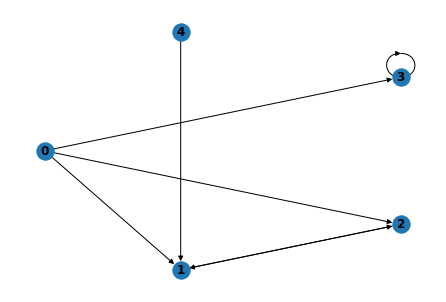

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
G = to_networkx(data,to_undirected=data.is_undirected())
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold') #self loop on 3; bidirectional 

In [ ]:
print(f"Keys: {data.keys}")
print(f"Edge_attr: {'edge_attr' in data}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Number of Node features: {data.num_node_features}")
print(f"Isolated Nodes: {data.has_isolated_nodes()}")
print(f"Self Loops: {data.has_self_loops()}")
print(f"Directed graph: {data.is_directed()}")

Keys: ['x', 'edge_index']
Edge_attr: False
Number of Nodes: 3
Number of Edges: 4
Number of Node features: 1
Isolated Nodes: False
Self Loops: False
Directed graph: False


# Common Benchmark Datasets




> torch_geometric also supports some common datasets. One of such dataset is `Enzymes`. `Enzyme` contains total 600 graphs with 6 classes. We will split this data into training set and test set. Training set contains 540 graphs (90%) and test set contains 60 graphs (10%).  





In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
train_dataset = dataset[:540]
test_dataset = dataset[540:]

Extracting ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


# Mini-Batch & Dataloader

 > We will use the dataloader to split the training and testing set into batches. This is exactly same as normal pytorch dataloader.

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1)

# Training GNN

> Now we will train a simple Graph Neural Network on Cora dataset, Cora dataset is supported by torch_geometric

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data', name='Cora')

Processing...
Done!


 > What is Graph Convolution? and How is it different from Convolutions. 


 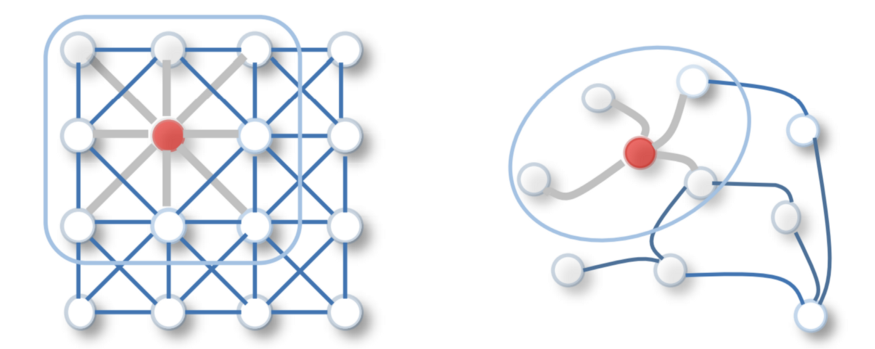



In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    if epoch%20==0:
      print(f'Epoch: {epoch} Accuracy: {acc:.4f}')


Epoch: 0 Accuracy: 0.3140
Epoch: 20 Accuracy: 0.8130
Epoch: 40 Accuracy: 0.7950
Epoch: 60 Accuracy: 0.7910
Epoch: 80 Accuracy: 0.7970
Epoch: 100 Accuracy: 0.8020
Epoch: 120 Accuracy: 0.7990
Epoch: 140 Accuracy: 0.8130
Epoch: 160 Accuracy: 0.8040
Epoch: 180 Accuracy: 0.8110


Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  